### Overview

This is a notepad to explore data from the DPE/BNDB databases described modelled energy consumption in buildings in France.

The aim is to arrive at meausures of per capita annual energy consumption and emissions in (probably only residential) buildings, which can be combined with similar meausures of energy and emissions per capita from passenger transport, in order to facilitate a combined analysis of urban form and emissions from residential energy and passenger transport.

The spatial unit will be something mid-resolution, likely postcode or similar.

As data from [BNDB](https://www.bdnb.eu/) contains consistent and high quality building energy intensity estimates for only a sample of all buildings, the energy data will be scaled up using more comprehensive building stock estimates, such as from [EUBUCCO](https://eubucco.com/).

### Challenges

A number of data consistency and completeness challenges need to be overcome in order to enable estimates of complete residential building energy demand within a given spatial unit, such as a postcode, which are detailed further below.

 1. *Estimate of absolute energy consumption for a dwelling.* DPE certificates (using the more recent/reliable 2021 method) estimate energy consumption and emissions as final and primary energy consumption, and GHG emissions per m2 *living area* or *net floor area*, depending on the source. One [blog post](https://blog.checkandvisit.com/dpe-surface-habitable/) says that living area (which they distinguish from net floor area) is the denominator for the energy/emission intensities. It seems from an article from [Largtigue et al., 2022](https://link.springer.com/article/10.1007/s12053-022-10036-x) that net floor area is the denominator. Perhaps, these people actually refer to the same thing. 
 In any case, the issue which we will see below, is that not all dwellings include the record of their living area, so it is not possible to directly estimate the absoluate energy consumption for the dwelling. 

 2. *Knowing how many buildings, or how much floorspace is represented by the sample of buildings with DPEs* is the next challenge. For a given postcode for example, we may have 1000 dwellings with a DPE, but in order to scale that to estimate energy consumption for all dwellings in that postcode, we need to know what is the ratio between the buildings with DPEs and the total residential stock (before even considering issues of bias or representativeness). The entire DPE data covers buildings which have a DPE rating using either the 2012 or 2021 method, and building type is available in one of the BNDB files, but that probably doesn't cover all dwellings. EUBUCCO contains a comprehensive source to estimate the total number and total floor area of all buildings, but not every building has a type attribute, so we don't know if the sum of all buildings marked as residential in EUBUCCO refers to the entire residential stock in any location. Extent of coverage varies, but probably EUBUCCO will give us an underestimate of residential building stock in French urban regions.

 3. *Converting living area to total floor area*. If we resolve the above challenges, and we know the energy consumption and the living floor area in a sample of buildings, AND we know the total gross floor area of the area to be represented, we still have one more barrier to overcome in order to scale the sample to the total area, we need to know the ratio between living area and gross floor area. i.e. we would want to scale by taking the ratio of living area in the whole postcode to living area in the sample of buildings with DPEs, but we don't know the living area of the total postcode, only the gross floor area. Alternatively, we could scale by gross floor area (and assume that the ratio of living:gross area is the same bw the sample and the total stock), but in this case we would also need to know the gross floor area of buildings with DPEs. A gross floor area column is not included in the DPE buildings, but another data file appears to contain building footprint and number of stories for each building which could be used to estimate gross floor area, but so far these data look unreliable (often the gross floor area calculated as footprint*stories gives an area smaller than the reported living area, which cannot be true).

### Demonstration

We will explore and demonstrate the data availability and challenges of the DPE data for the French department of Nord (#59).

The data are downloaded from [here](https://www.data.gouv.fr/fr/datasets/base-de-donnees-nationale-des-batiments/) and data dictionaries and descriptions of the various files and variables can be found [here](https://www.bdnb.eu/schema/latest/relationships.html)

In [1]:
# load required libraries

import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import pickle
from shapely.validation import make_valid
from citymob import remove_holes, remove_invalid_geoms, remove_slivers, import_csv_w_wkt_to_gdf
import sys
from shapely.geometry import Point, Polygon
# Import the geocoding tool
from geopandas.tools import geocode

The [dpe_logement](https://www.bdnb.eu/schema/latest/tables/dpe_logement.html) file contains housing DPE data including energy and emission intensities for residential dwellings, and physical building characteristics 

In [2]:
dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/dpe_logement.csv')
dpe_log_col=dpe_log.columns.to_list() # there are a lot of columns
dpe_log.head()

C:\Users\peter\AppData\Local\Temp\ipykernel_20040\2919012715.py:1: DtypeWarning: Columns (8,17,18,19,20,26,29,35,39,42,48,70,75,76,77,84,85,86,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/dpe_logement.csv')


,identifiant_dpe,code_departement_insee,arrete_2021,type_dpe,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,version,date_etablissement_dpe,date_reception_dpe,...,type_porte,surface_porte,u_porte,classe_inertie,deperdition_mur,deperdition_baie_vitree,deperdition_plancher_bas,deperdition_plancher_haut,deperdition_pont_thermique,deperdition_porte
0,0059L1000001@,59,0,dpe arrêté 2012 3cl immeuble,immeuble,1989-2000,1996.0,NaN,NaN,2017/05/30 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
1,0059L1000002A,59,0,dpe arrêté 2012 3cl immeuble,immeuble,1948-1974,1971.0,NaN,NaN,2017/05/31 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
2,0059L1000003,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/07/25 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
3,0059L1000004,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/07/25 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
4,0059L1000005D,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/08/04 00:00:00,...,NaN,NaN,NaN,Lourde,NaN,NaN,NaN,NaN,NaN,NaN


Checking the columns in dpe_log for area ('surface') related variables, we have `surface_habitable_immeuble` which is living area per building, for whole-building level DPEs (which may contain many individual dwellings) and apartments DPE which include collective use (I presume this refers to when energy for e.g. space or water heating is generated per building or floor, or even from district heat)). Then we have also `surface_habitable_logement` which is living area per dwelling.

In [3]:
dpe_log.loc[dpe_log['arrete_2021']==1, 'surface_habitable_logement']

233065     61.00
233066     43.14
233067     80.48
233068     78.35
233069     90.00
           ...  
284871    179.17
284872    149.70
284873     85.00
284874    124.00
284875     32.25
Name: surface_habitable_logement, Length: 51811, dtype: float64

Almost all records with 2021 method DPE ratings include living area, while none of those using the earlier DPE rating include living area, so we will proceed using only records using the 2021 methodology

In [4]:
sum(~dpe_log.loc[dpe_log['arrete_2021']==1, 'surface_habitable_immeuble'].isna() | ~dpe_log.loc[dpe_log['arrete_2021']==1, 'surface_habitable_logement'].isna()) / len(dpe_log.loc[dpe_log['arrete_2021']==1,])

0.9976452876802223

In [5]:
sum(~dpe_log.loc[dpe_log['arrete_2021']==0, 'surface_habitable_immeuble'].isna() | ~dpe_log.loc[dpe_log['arrete_2021']==0, 'surface_habitable_logement'].isna()) / len(dpe_log.loc[dpe_log['arrete_2021']==0,])

0.0

In [6]:
print('total number of records', len(dpe_log))
dpe_log=dpe_log.loc[dpe_log['arrete_2021']==1,]
print('total number of records with 2021 method DPE', len(dpe_log))

total number of records 284876
total number of records with 2021 method DPE 51811


In [7]:
# check how many remaning records have valid energy/emissions intensities
print(sum(~dpe_log['emission_ges_5_usages_m2'].isna()), ' dwellings with 2021 method emission intensity,', sum(dpe_log['emission_ges_5_usages_m2']==0), 'of which are 0 (invalid)')
print(sum(~dpe_log['conso_5_usages_ef_m2'].isna()), ' dwellings with 2021 method final energy intensity,', sum(dpe_log['conso_5_usages_ep_m2']==0), 'of which are 0 (invalid)')


51805  dwellings with 2021 method emission intensity, 0 of which are 0 (invalid)
51805  dwellings with 2021 method final energy intensity, 0 of which are 0 (invalid)


So, for the records for which have valid 2021 energy/emission intensities and living area, lets find the corresponding addresses and see if we can estimate the gross floor area and compare it with the living floor area

In [8]:
# first load the addresses file, this let's us merge later with the building groups file. 
add=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/adresse.csv',dtype={'code_postal':str})
add.head()

,WKT,cle_interop_adr,code_departement_insee,numero,rep,nom_voie,type_voie,code_commune_insee,code_postal,libelle_commune,source
0,POINT (761237.127001409 6993772.84289119),02-AISN-276828,59,7,NaN,des bruniers,rue,59241,NaN,Floyon,Arcep
1,POINT (737080.587487689 7028881.04234662),186855650575723,59,6,B,des dentellieres,avenue,59606,NaN,Valenciennes,Arcep
2,POINT (736851.339650684 7029549.26831763),186855700165357,59,43,B,du senateur girard,avenue,59606,NaN,Valenciennes,Arcep
3,POINT (736950.725348686 7029579.81433162),186855740577684,59,19,NaN,du marechal foch,avenue,59606,NaN,Valenciennes,Arcep
4,POINT (737085.741848688 7029422.28830762),186856150579663,59,3,NaN,girot,cour,59606,NaN,Valenciennes,Arcep


In [9]:
# then load the file with ids containing the relationship between addresses ('cle_interop_adr'), building groups ('batiment_groupe_id'), and dpe ('identifiant_dpe')
rel_bldgroup_dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/rel_batiment_groupe_dpe_logement.csv')
rel_bldgroup_dpe_log.head()

,batiment_groupe_id,identifiant_dpe,code_departement_insee,cle_interop_adr,adresse_brut,adresse_geocodee,fiabilite_geocodage
0,59512000IN0090_b45ee30e81da3f7,1959V2014824D,59,59512_2540_00095,95 Rue D Hem 59100 Roubaix,95 Rue d’Hem 59100 Roubaix,très fiable
1,59512000IO0196_67d7fd8ce86b410,1459V2008109X,59,59512_2720_00009,9 Rue Ingres 59100 Roubaix,9 Rue Ingres 59100 Roubaix,très fiable
2,59512000IK0019_5206a20845e2bc4,1659L1003092T,59,59512_1300_00036,36 Rue Coligny 59100 Roubaix,36 Rue Coligny 59100 Roubaix,très fiable
3,59512000IK0172_1be81f80ce0da53,1559V2010882@,59,59512_1300_00009,9 Rue Coligny 59100 Roubaix,9 Rue Coligny 59100 Roubaix,très fiable
4,59512000IK0153_cfaf8654038c76e,1659V1003062R,59,59512_4250_00022,22 Rue Pascal 59100 Roubaix,22 Rue Pascal 59100 Roubaix,très fiable


In [141]:
print(len(rel_bldgroup_dpe_log['batiment_groupe_id'].unique()))
print(len(rel_bldgroup_dpe_log['identifiant_dpe'].unique()))
print(len(rel_bldgroup_dpe_log['cle_interop_adr'].unique()))
print(len(rel_bldgroup_dpe_log))

166076
284876
179859
310970


In [144]:
rel_bldgroup_dpe_log['identifiant_dpe'].value_counts()

1759V1011530R    104
2159E0304383I     87
1459V2000017N     49
1759V1010309U     49
1459V1007036U     47
                ... 
1359L2000850Q      1
1959L2000788G      1
1559V2006892F      1
1559V2006893G      1
2259E1762447T      1
Name: identifiant_dpe, Length: 284876, dtype: int64

In [147]:
rel_bldgroup_dpe_log['batiment_groupe_id'].value_counts()

uf593830415591_4408e771feaa9f8    450
59009000NE0005_4777689bd5e4412    359
uf593500141781_05a7d67fe5c3972    261
59009000NM0372_bdafb99d26b83c0    256
uf593500141682_e9a78588c232368    233
                                 ... 
591940000A1414_bbabc30dd1914fb      1
591940000A1401_abce6b8800eb142      1
591940000A1382_f6cf6d8a0ddab42      1
591940000A1297_ebfe480decf4a6d      1
590030000B0221_f1d4f8ac4eab2c4      1
Name: batiment_groupe_id, Length: 166076, dtype: int64

In [143]:
rel_bldgroup_dpe_log.loc[:,['batiment_groupe_id','identifiant_dpe']].drop_duplicates()

,batiment_groupe_id,identifiant_dpe
0,59512000IN0090_b45ee30e81da3f7,1959V2014824D
1,59512000IO0196_67d7fd8ce86b410,1459V2008109X
2,59512000IK0019_5206a20845e2bc4,1659L1003092T
3,59512000IK0172_1be81f80ce0da53,1559V2010882@
4,59512000IK0153_cfaf8654038c76e,1659V1003062R
...,...,...
310965,59002000AT0052_d9774e049faf697,2259E0968775X
310966,59002000AT0069_2a269790fd3ba27,2159E0003711A
310967,59002000AT0077_0243678e5c21ed5,2159E0765823A
310968,59002000ZE0100_2fb4ca720f55a20,2259E0587196U


In [10]:
# then load the gdf which contains geometries (footprints) of each building group
add_gdf=gpd.read_file('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_gpkg/gpkg/bdnb.gpkg')

In [11]:
# actually it only contains point geometries, not polygons
add_gdf.head()

,cle_interop_adr,code_departement_insee,numero,rep,nom_voie,type_voie,code_commune_insee,code_postal,libelle_commune,source,nb_bat_grp,nb_bat_grp_hors_dep,geometry
0,02-AISN-276828,59,7,None,des bruniers,rue,59241,None,Floyon,Arcep,1,1,POINT (761237.127 6993772.843)
1,186855650575723,59,6,B,des dentellieres,avenue,59606,None,Valenciennes,Arcep,1,1,POINT (737080.587 7028881.042)
2,186855700165357,59,43,B,du senateur girard,avenue,59606,None,Valenciennes,Arcep,1,1,POINT (736851.340 7029549.268)
3,186855740577684,59,19,None,du marechal foch,avenue,59606,None,Valenciennes,Arcep,1,1,POINT (736950.725 7029579.814)
4,186856150579663,59,3,None,girot,cour,59606,None,Valenciennes,Arcep,1,1,POINT (737085.742 7029422.288)


In [12]:
# the building construction file is the one that contains building group polygons
gdf_BC = import_csv_w_wkt_to_gdf('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/batiment_construction.csv',crs=2154,geometry_col='WKT')
gdf_BC

,WKT,batiment_construction_id,batiment_groupe_id,code_departement_insee,code_iris,code_commune_insee,s_geom_cstr,hauteur,altitude_sol,fictive_geom_cstr,geometry
0,"MULTIPOLYGON (((648120.2 7104434.6,648120.8 71...",BATIMENT0000000056598726-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,4.0,7.0,0,"MULTIPOLYGON (((648120.200 7104434.600, 648120..."
1,"MULTIPOLYGON (((669133.0 7105045.6,669127.6 71...",BATIMENT0000000056596362-2,592604040A0746_e08c048eccb8b8b,59,592600000.0,59260.0,28.0,1.6,0.0,0,"MULTIPOLYGON (((669133.000 7105045.600, 669127..."
2,MULTIPOLYGON (((655725.5407313 7103268.5745565...,BATIMENT0000000056603258-4,59155000AB0454_c7a93be4dd46566,59,591550101.0,59155.0,14.0,8.0,3.0,0,"MULTIPOLYGON (((655725.541 7103268.575, 655728..."
3,"MULTIPOLYGON (((704215.0 7036515.8,704215.9388...",BATIMENT0000000046102397-2,uf590280373968_89dcf46922915ba,59,NaN,59028.0,60.0,5.0,NaN,0,"MULTIPOLYGON (((704215.000 7036515.800, 704215..."
4,MULTIPOLYGON (((703688.537616351 7036434.21480...,BATIMENT0000000046102442-1,uf590280012251_4fca4c9f5acb718,59,590280103.0,NaN,24.0,4.7,22.0,0,"MULTIPOLYGON (((703688.538 7036434.215, 703698..."
...,...,...,...,...,...,...,...,...,...,...,...
1012296,MULTIPOLYGON (((636715.66902653 7100960.020757...,u116pu3x94c1s84x0t61uf592720337864,uf592720337864_8b769806f01413f,59,592720101.0,59272.0,NaN,6.0,NaN,1,"MULTIPOLYGON (((636715.669 7100960.021, 636718..."
1012297,MULTIPOLYGON (((636727.716498794 7101020.10733...,u116pu9dszmpevxmhw29uf592720381593,uf592720381593_c7c05fa4d101938,59,592720101.0,59272.0,NaN,6.0,NaN,1,"MULTIPOLYGON (((636727.716 7101020.107, 636730..."
1012298,MULTIPOLYGON (((636723.992324715 7101070.20948...,u116pu9t7g4wkzfp7y8v59272000AL0617,59272000AL0617_58c51d221f4f5b6,59,592720101.0,59272.0,NaN,5.0,NaN,1,"MULTIPOLYGON (((636723.992 7101070.209, 636727..."
1012299,MULTIPOLYGON (((636918.128566155 7101093.77527...,u116puewdwjyzsb0srxe59272000AH0489,59272000AH0489_73baa030a3555ff,59,592720101.0,59272.0,NaN,5.0,NaN,1,"MULTIPOLYGON (((636918.129 7101093.775, 636919..."


The `s_geom_cstr` column actually seems like a reliable estiamte of polygon areas. It is described [here](https://www.bdnb.eu/schema/latest/tables/batiment_construction.html) as the 'Floor area of ​​building geometry m²' 

After merging gdf_BC with dpe file, we can multiply footprint by N stories to estimate the total GFA.



In [13]:
gdf_BC.to_crs(3035,inplace=True)
gdf_BC['Area_footprint']=gdf_BC.area
gdf_BC.head()


,WKT,batiment_construction_id,batiment_groupe_id,code_departement_insee,code_iris,code_commune_insee,s_geom_cstr,hauteur,altitude_sol,fictive_geom_cstr,geometry,Area_footprint
0,"MULTIPOLYGON (((648120.2 7104434.6,648120.8 71...",BATIMENT0000000056598726-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,4.0,7.0,0,"MULTIPOLYGON (((3779363.955 3131157.890, 37793...",31.553311
1,"MULTIPOLYGON (((669133.0 7105045.6,669127.6 71...",BATIMENT0000000056596362-2,592604040A0746_e08c048eccb8b8b,59,592600000.0,59260.0,28.0,1.6,0.0,0,"MULTIPOLYGON (((3800273.658 3129748.091, 38002...",27.710019
2,MULTIPOLYGON (((655725.5407313 7103268.5745565...,BATIMENT0000000056603258-4,59155000AB0454_c7a93be4dd46566,59,591550101.0,59155.0,14.0,8.0,3.0,0,"MULTIPOLYGON (((3786799.279 3129268.048, 37868...",14.201264
3,"MULTIPOLYGON (((704215.0 7036515.8,704215.9388...",BATIMENT0000000046102397-2,uf590280373968_89dcf46922915ba,59,NaN,59028.0,60.0,5.0,NaN,0,"MULTIPOLYGON (((3828606.730 3058253.637, 38286...",60.012103
4,MULTIPOLYGON (((703688.537616351 7036434.21480...,BATIMENT0000000046102442-1,uf590280012251_4fca4c9f5acb718,59,590280103.0,NaN,24.0,4.7,22.0,0,"MULTIPOLYGON (((3828076.042 3058222.616, 38280...",23.604135


In [14]:
gdf_BC['area_ratio']=gdf_BC['s_geom_cstr']/gdf_BC['Area_footprint']
gdf_BC['area_ratio'].describe()

count    986569.000000
mean          1.003163
std           0.007631
min           0.925510
25%           1.000295
50%           1.003144
75%           1.005963
max           1.080847
Name: area_ratio, dtype: float64

In [56]:
# restrict dpe to the columns of interest
cols=['identifiant_dpe','arrete_2021','type_batiment_dpe','periode_construction_dpe','annee_construction_dpe','nombre_niveau_logement','nombre_niveau_immeuble', 'surface_habitable_immeuble',
                       'surface_habitable_logement', 'conso_5_usages_ep_m2','conso_5_usages_ef_m2', 'emission_ges_5_usages_m2',
                       'surface_plancher_bas_totale','surface_plancher_haut_totale']
dpe=dpe_log.loc[:,cols]
dpe.head()

,identifiant_dpe,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,surface_habitable_immeuble,surface_habitable_logement,conso_5_usages_ep_m2,conso_5_usages_ef_m2,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale
233065,2100E0078172Q,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN
233066,2100E0089778A,1,appartement,2006-2012,2006.0,1.0,NaN,NaN,43.14,246.0,107.0,7.0,NaN,NaN
233067,2100E0126751B,1,maison,avant 1948,1947.0,1.0,NaN,NaN,80.48,607.0,390.0,63.0,NaN,NaN
233068,2100E0145628C,1,appartement,avant 1948,1947.0,1.0,NaN,NaN,78.35,153.0,137.0,29.0,NaN,NaN
233069,2100E0218487J,1,maison,1948-1974,1948.0,1.0,NaN,NaN,90.00,154.0,121.0,23.0,NaN,NaN


In [57]:
# add other building groupd and address ids
dpe=rel_bldgroup_dpe_log.loc[:,['identifiant_dpe','batiment_groupe_id', 'cle_interop_adr','adresse_geocodee']].merge(dpe,on='identifiant_dpe',how='right')
dpe.head()

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,surface_habitable_immeuble,surface_habitable_logement,conso_5_usages_ep_m2,conso_5_usages_ef_m2,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale
0,2100E0078172Q,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN
1,2100E0078172Q,595070000A5692_4adf09e8c87dbb0,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN
2,2100E0078172Q,595070000A5692_9f39260feb51a1f,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN
3,2100E0078172Q,595070000A5692_f48adc5bb79b2c2,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN
4,2100E0089778A,59599000CM0626_26543bfbd2bf402,59599_3625_00002,2 Allee De La Marbrerie 59200 Tourcoing,1,appartement,2006-2012,2006.0,1.0,NaN,NaN,43.14,246.0,107.0,7.0,NaN,NaN


In [62]:
print('N unique building groups:',len(dpe['batiment_groupe_id'].unique()))
print('N unique DPEs:',len(dpe['identifiant_dpe'].unique()))
print('N unique addresses:',len(dpe['cle_interop_adr'].unique()))
print('Total number of unique records:',len(dpe))

N unique building groups: 36314
N unique DPEs: 51811
N unique addresses: 39316
Total number of unique records: 56629


In [67]:
# a surprising observation is that the same DPE is in some cases mapped to numerous building groups
dpe['identifiant_dpe'].value_counts().head(25)

2159E0304383I    87
2259E1268070G    42
2259E1354439D    42
2259E1284573Z    42
2259E1284588O    42
2259E1268049L    42
2259E1267044U    42
2259E1267143P    42
2259E1268157P    42
2259E1284146O    42
2259E1267204Y    42
2259E1284803V    42
2259E1284563P    42
2259E1284930S    42
2259E1285018C    42
2259E1267589T    42
2259E1266556A    42
2259E1285118Y    42
2259E1354428S    42
2259E1267375N    42
2259E1266681V    42
2259E0450472E    29
2259E1194399T    28
2259E0219069B    28
2159E1025866R    27
Name: identifiant_dpe, dtype: int64

In [35]:
dpe['type_batiment_dpe'].value_counts()

maison         34779
appartement    21681
immeuble         169
Name: type_batiment_dpe, dtype: int64

In [208]:
dpe['BG_adr']=dpe['batiment_groupe_id']+'-'+dpe['cle_interop_adr']
dpe.head()

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,surface_habitable_immeuble,surface_habitable_logement,conso_5_usages_ep_m2,conso_5_usages_ef_m2,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale,BG_adr
0,2100E0078172Q,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN,595070000A5692_88fd84fef2f8a99-59507_0890_00200
1,2100E0078172Q,595070000A5692_4adf09e8c87dbb0,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN,595070000A5692_4adf09e8c87dbb0-59507_0890_00200
2,2100E0078172Q,595070000A5692_9f39260feb51a1f,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN,595070000A5692_9f39260feb51a1f-59507_0890_00200
3,2100E0078172Q,595070000A5692_f48adc5bb79b2c2,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,NaN,61.00,227.0,98.0,7.0,NaN,NaN,595070000A5692_f48adc5bb79b2c2-59507_0890_00200
4,2100E0089778A,59599000CM0626_26543bfbd2bf402,59599_3625_00002,2 Allee De La Marbrerie 59200 Tourcoing,1,appartement,2006-2012,2006.0,1.0,NaN,NaN,43.14,246.0,107.0,7.0,NaN,NaN,59599000CM0626_26543bfbd2bf402-59599_3625_00002


In [210]:
len(dpe['BG_adr'].drop_duplicates())

42434

In [38]:
gdf_BC.columns

Index(['WKT', 'batiment_construction_id', 'batiment_groupe_id',
       'code_departement_insee', 'code_iris', 'code_commune_insee',
       's_geom_cstr', 'hauteur', 'altitude_sol', 'fictive_geom_cstr',
       'geometry', 'Area_footprint', 'area_ratio'],
      dtype='object')

In [37]:
gdf_BC.head()

,WKT,batiment_construction_id,batiment_groupe_id,code_departement_insee,code_iris,code_commune_insee,s_geom_cstr,hauteur,altitude_sol,fictive_geom_cstr,geometry,Area_footprint,area_ratio
0,"MULTIPOLYGON (((648120.2 7104434.6,648120.8 71...",BATIMENT0000000056598726-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,4.0,7.0,0,"MULTIPOLYGON (((3779363.955 3131157.890, 37793...",31.553311,1.014157
1,"MULTIPOLYGON (((669133.0 7105045.6,669127.6 71...",BATIMENT0000000056596362-2,592604040A0746_e08c048eccb8b8b,59,592600000.0,59260.0,28.0,1.6,0.0,0,"MULTIPOLYGON (((3800273.658 3129748.091, 38002...",27.710019,1.010465
2,MULTIPOLYGON (((655725.5407313 7103268.5745565...,BATIMENT0000000056603258-4,59155000AB0454_c7a93be4dd46566,59,591550101.0,59155.0,14.0,8.0,3.0,0,"MULTIPOLYGON (((3786799.279 3129268.048, 37868...",14.201264,0.985828
3,"MULTIPOLYGON (((704215.0 7036515.8,704215.9388...",BATIMENT0000000046102397-2,uf590280373968_89dcf46922915ba,59,NaN,59028.0,60.0,5.0,NaN,0,"MULTIPOLYGON (((3828606.730 3058253.637, 38286...",60.012103,0.999798
4,MULTIPOLYGON (((703688.537616351 7036434.21480...,BATIMENT0000000046102442-1,uf590280012251_4fca4c9f5acb718,59,590280103.0,NaN,24.0,4.7,22.0,0,"MULTIPOLYGON (((3828076.042 3058222.616, 38280...",23.604135,1.016771


In [71]:
df_BC=pd.DataFrame(gdf_BC.drop(columns=['WKT','geometry']))

In [70]:
print('N unique building constructions:',len(gdf_BC['batiment_construction_id'].unique()))
print('N unique building groups:',len(gdf_BC['batiment_groupe_id'].unique()))

N unique building constructions: 1012301
N unique building groups: 890603


In [76]:
dpe_bc=gpd.GeoDataFrame(dpe.merge(gdf_BC.loc[:,['batiment_construction_id', 'batiment_groupe_id','s_geom_cstr', 'hauteur', 'geometry', 'Area_footprint', 'area_ratio']],on='batiment_groupe_id',how='inner'),geometry='geometry')
dpe_bc.head()

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,...,conso_5_usages_ef_m2,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale,batiment_construction_id,s_geom_cstr,hauteur,geometry,Area_footprint,area_ratio
0,2100E0078172Q,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,...,98.0,7.0,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356
1,2159E0078306B,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,2006-2012,2006.0,1.0,NaN,...,87.0,6.0,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356
2,2159E0093983A,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,2006-2012,2006.0,1.0,NaN,...,81.0,5.0,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356
3,2159E0196882R,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,2006-2012,2006.0,1.0,NaN,...,69.0,4.0,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356
4,2159E0322387U,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,...,108.0,7.0,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356


In [77]:
dpe_bc['living_area']=dpe_bc['surface_habitable_logement'].copy()
dpe_bc.loc[dpe_bc['living_area'].isna(),'living_area']=dpe_bc.loc[dpe_bc['living_area'].isna(),'surface_habitable_immeuble']

dpe_bc_df=pd.DataFrame(dpe_bc.drop(columns=['geometry']))

In [75]:
sum(dpe_bc['living_area'].isna())

2364

We see again a complex many:many mapping of building groups, constructions, DPEs, and addresses. This seems to be due to a number of reasons, including the use of one id (e.g. address) when in fact multiple buildings are being referred to.

In [79]:
print('N unique building groups:',len(dpe_bc['batiment_groupe_id'].unique()))
print('N unique building constructions:',len(dpe_bc['batiment_construction_id'].unique()))
print('N unique DPEs:',len(dpe_bc['identifiant_dpe'].unique()))
print('N unique addresses:',len(dpe_bc['cle_interop_adr'].unique()))
print('Total number of unique records:',len(dpe_bc))


N unique building groups: 36314
N unique building constructions: 62063
N unique DPEs: 51811
N unique addresses: 39316
Total number of unique records: 386713


In [90]:
dpe_bc['batiment_construction_id'].value_counts().head()

BATIMENT0000000287677600-1    197
BATIMENT0000000291023190-1    180
BATIMENT0000000291022726-1    180
BATIMENT0000000291023189-1    180
BATIMENT0000000291023192-1    180
Name: batiment_construction_id, dtype: int64

In [93]:
dpe_bc['batiment_groupe_id'].value_counts().head()

uf594560419272_54cd85991256774    80630
uf596160427289_46262b0ae56b955    54621
uf596160250976_a2abb4d165b1810    45188
uf592760381753_19d72ff79c66604    10206
uf591700063215_1f9d20efff1e048    10059
Name: batiment_groupe_id, dtype: int64

In [92]:
dpe_bc['cle_interop_adr'].value_counts().head()

59616_0087_01463      2288
59616_0590_00986      2288
59456_0139_00004      2199
59616_g7sk71_00990    1716
59616_g7sk71_01008    1716
Name: cle_interop_adr, dtype: int64

First look at buildings with the same DPE id. 

In [152]:
# it is initially unlcear why many of the DPEs assigned to multiple buildings all have a count of 733. 
dpe_bc['identifiant_dpe'].value_counts().head(113)

2159E0331027C    733
2159E0860396L    733
2159E0869718Z    733
2159E0870064H    733
2159E0870352J    733
                ... 
2259E0934107N    733
2259E0934376W    733
2259E1114563D    639
2259E1236687F    639
2259E1165956U    639
Name: identifiant_dpe, Length: 113, dtype: int64

In [104]:
# for ID 2159E0331027C, there is only one associated address and one building group ID, but many building construction IDs.
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0331027C',['adresse_geocodee','batiment_groupe_id','batiment_construction_id']].value_counts()

adresse_geocodee                         batiment_groupe_id              batiment_construction_id  
22 Avenue Emile Zola 59146 Pecquencourt  uf594560419272_54cd85991256774  BATIMENT0000000291225446-1    1
                                                                         BATIMENT0000000291226283-1    1
                                                                         BATIMENT0000000291226285-1    1
                                                                         BATIMENT0000000291226286-1    1
                                                                         BATIMENT0000000291226287-2    1
                                                                                                      ..
                                                                         BATIMENT0000000291225814-1    1
                                                                         BATIMENT0000000291225815-1    1
                                                            

<AxesSubplot:>

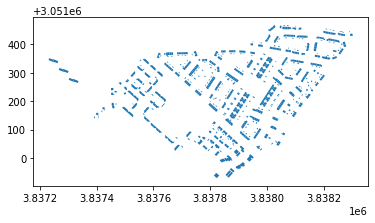

In [95]:
# plotting the geometries associated with this DPE ID, despite only one address, it is clear that many buildings are represented. 
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0331027C',:].plot()

<AxesSubplot:>

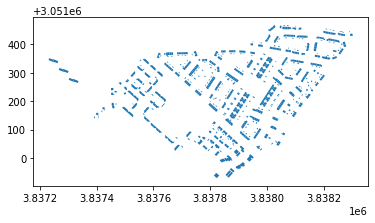

In [119]:
# 2159E0860396L
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0860396L',:].plot()

<AxesSubplot:>

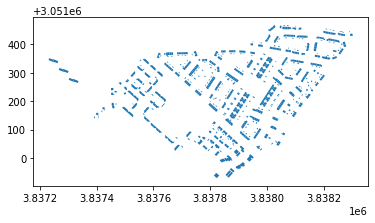

In [118]:
# 2259E0934376W
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2259E0934376W',:].plot()

In [121]:
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0331027C',:].head()

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,...,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale,batiment_construction_id,s_geom_cstr,hauteur,geometry,Area_footprint,area_ratio,living_area
10117,2159E0331027C,uf594560419272_54cd85991256774,59456_0139_00022,22 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,21.0,NaN,NaN,BATIMENT0000000291225724-1,43.0,5.3,"MULTIPOLYGON (((3838028.930 3051388.713, 38380...",43.271828,0.993718,79.0
10118,2159E0331027C,uf594560419272_54cd85991256774,59456_0139_00022,22 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,21.0,NaN,NaN,BATIMENT0000000291226040-1,7.0,9.0,"MULTIPOLYGON (((3837917.792 3051305.495, 38379...",6.577052,1.064307,79.0
10119,2159E0331027C,uf594560419272_54cd85991256774,59456_0139_00022,22 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,21.0,NaN,NaN,BATIMENT0000000291226041-1,7.0,9.0,"MULTIPOLYGON (((3837816.283 3051313.402, 38378...",6.731630,1.039867,79.0
10120,2159E0331027C,uf594560419272_54cd85991256774,59456_0139_00022,22 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,21.0,NaN,NaN,BATIMENT0000000291226155-1,9.0,9.0,"MULTIPOLYGON (((3838099.602 3051308.172, 38381...",9.334522,0.964163,79.0
10121,2159E0331027C,uf594560419272_54cd85991256774,59456_0139_00022,22 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,21.0,NaN,NaN,BATIMENT0000000291226332-1,7.0,9.0,"MULTIPOLYGON (((3837952.030 3051409.823, 38379...",6.731614,1.039869,79.0


In [170]:
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0331027C','adresse_geocodee']

10117    22 Avenue Emile Zola 59146 Pecquencourt
10118    22 Avenue Emile Zola 59146 Pecquencourt
10119    22 Avenue Emile Zola 59146 Pecquencourt
10120    22 Avenue Emile Zola 59146 Pecquencourt
10121    22 Avenue Emile Zola 59146 Pecquencourt
                          ...                   
10845    22 Avenue Emile Zola 59146 Pecquencourt
10846    22 Avenue Emile Zola 59146 Pecquencourt
10847    22 Avenue Emile Zola 59146 Pecquencourt
10848    22 Avenue Emile Zola 59146 Pecquencourt
10849    22 Avenue Emile Zola 59146 Pecquencourt
Name: adresse_geocodee, Length: 733, dtype: object

In [171]:
check=dpe_bc.loc[:,['identifiant_dpe','adresse_geocodee']].copy()
check

,identifiant_dpe,adresse_geocodee
0,2100E0078172Q,200 Rue Roger Salengro 59790 Ronchin
1,2159E0078306B,200 Rue Roger Salengro 59790 Ronchin
2,2159E0093983A,200 Rue Roger Salengro 59790 Ronchin
3,2159E0196882R,200 Rue Roger Salengro 59790 Ronchin
4,2159E0322387U,200 Rue Roger Salengro 59790 Ronchin
...,...,...
386708,2291E0862735R,44 Rue Moreau 59171 Hélesmes
386709,2291E1168868A,20 Rue Du Triez De Carihem 59100 Roubaix
386710,2295E0066387B,8 Rue Saint Exupery 59560 Comines
386711,2295E0581827R,66 Rue Alexander Selkirk 59495 Leffrinckoucke


In [172]:
check.drop_duplicates()

,identifiant_dpe,adresse_geocodee
0,2100E0078172Q,200 Rue Roger Salengro 59790 Ronchin
1,2159E0078306B,200 Rue Roger Salengro 59790 Ronchin
2,2159E0093983A,200 Rue Roger Salengro 59790 Ronchin
3,2159E0196882R,200 Rue Roger Salengro 59790 Ronchin
4,2159E0322387U,200 Rue Roger Salengro 59790 Ronchin
...,...,...
386708,2291E0862735R,44 Rue Moreau 59171 Hélesmes
386709,2291E1168868A,20 Rue Du Triez De Carihem 59100 Roubaix
386710,2295E0066387B,8 Rue Saint Exupery 59560 Comines
386711,2295E0581827R,66 Rue Alexander Selkirk 59495 Leffrinckoucke


In [174]:
check['identifiant_dpe'].value_counts()

2159E0331027C    733
2159E0860396L    733
2159E0869718Z    733
2159E0870064H    733
2159E0870352J    733
                ... 
2259E0015224W      1
2259E0626823X      1
2259E0015266M      1
2259E0268715N      1
2298E0265285C      1
Name: identifiant_dpe, Length: 51811, dtype: int64

In [173]:
check['adresse_geocodee'].value_counts()

1463 Rue Antoine Lefevre 59690 Vieux-Condé    2288
986 Rue Marcel Sembat 59690 Vieux-Condé       2288
4 Avenue Emile Zola 59146 Pecquencourt        2199
990 Rue Rene Beth 59690 Vieux-Condé           1716
1008 Rue Rene Beth 59690 Vieux-Condé          1716
                                              ... 
18 Rue Des Trente 59100 Roubaix                  1
12 Le Village 59440 Dompierre-sur-Helpe          1
6 Rue Hiolin 59360 Le Cateau-Cambrésis           1
13 Rue Emile Dellette 59290 Wasquehal            1
141 Rue De La Chapelle 59870 Bouvignies          1
Name: adresse_geocodee, Length: 39315, dtype: int64

In [122]:
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0860396L',:].head()

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,...,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale,batiment_construction_id,s_geom_cstr,hauteur,geometry,Area_footprint,area_ratio,living_area
26243,2159E0860396L,uf594560419272_54cd85991256774,59456_0149_00005,5 Rue Des Freres Grimm 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,22.0,NaN,NaN,BATIMENT0000000291225724-1,43.0,5.3,"MULTIPOLYGON (((3838028.930 3051388.713, 38380...",43.271828,0.993718,52.0
26244,2159E0860396L,uf594560419272_54cd85991256774,59456_0149_00005,5 Rue Des Freres Grimm 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,22.0,NaN,NaN,BATIMENT0000000291226040-1,7.0,9.0,"MULTIPOLYGON (((3837917.792 3051305.495, 38379...",6.577052,1.064307,52.0
26245,2159E0860396L,uf594560419272_54cd85991256774,59456_0149_00005,5 Rue Des Freres Grimm 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,22.0,NaN,NaN,BATIMENT0000000291226041-1,7.0,9.0,"MULTIPOLYGON (((3837816.283 3051313.402, 38378...",6.731630,1.039867,52.0
26246,2159E0860396L,uf594560419272_54cd85991256774,59456_0149_00005,5 Rue Des Freres Grimm 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,22.0,NaN,NaN,BATIMENT0000000291226155-1,9.0,9.0,"MULTIPOLYGON (((3838099.602 3051308.172, 38381...",9.334522,0.964163,52.0
26247,2159E0860396L,uf594560419272_54cd85991256774,59456_0149_00005,5 Rue Des Freres Grimm 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,...,22.0,NaN,NaN,BATIMENT0000000291226332-1,7.0,9.0,"MULTIPOLYGON (((3837952.030 3051409.823, 38379...",6.731614,1.039869,52.0


In [130]:
# here we see that the 733 BCs with DPE ID 2159E0331027C are identical to the 733 BCs with DPE ID 2159E0860396L..
# probably the same story for all 110 DPEs which match to 733 batiment_construction_id  
# why do they have different DPEs?
# they refer to different building constructions, we just don't actually know which BC each DPE links to..
all(dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0331027C','batiment_construction_id'].values==dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0860396L','batiment_construction_id'].values)

True

In [161]:
rel_bldgroup_dpe_log.loc[rel_bldgroup_dpe_log['batiment_groupe_id']=='uf594560419272_54cd85991256774']

,batiment_groupe_id,identifiant_dpe,code_departement_insee,cle_interop_adr,adresse_brut,adresse_geocodee,fiabilite_geocodage
50466,uf594560419272_54cd85991256774,2159E0798077O,59,59456_0139_00050,50 Avenue Emile Zola 59146 Pecquencourt,50 Avenue Emile Zola 59146 Pecquencourt,très fiable
50467,uf594560419272_54cd85991256774,2159E0798309M,59,59456_0139_00052,52 Avenue Emile Zola 59146 Pecquencourt,52 Avenue Emile Zola 59146 Pecquencourt,très fiable
50468,uf594560419272_54cd85991256774,2159E0798520P,59,59456_0139_00062,62 Avenue Emile Zola 59146 Pecquencourt,62 Avenue Emile Zola 59146 Pecquencourt,très fiable
50469,uf594560419272_54cd85991256774,2159E0821024D,59,59456_0222_00032,32 Rue Lucien Bourdon 59146 Pecquencourt,32 Rue Lucien Bourdon 59146 Pecquencourt,très fiable
50470,uf594560419272_54cd85991256774,2159E0821209G,59,59456_0202_00008,8 Rue Mousseron 59146 Pecquencourt,8 Rue Jules Mousseron 59146 Pecquencourt,globalement fiable
...,...,...,...,...,...,...,...
288692,uf594560419272_54cd85991256774,1559L2003451S,59,59456_0296_00021,21 Rue Simone De Beauvoir 59146 Pecquencourt,21 Rue Simone de Beauvoir 59146 Pecquencourt,très fiable
288693,uf594560419272_54cd85991256774,1659L2000898F,59,59456_0149_00025,25 Rue Des Freres Grimm Cité Barrois 59146 Pec...,25 Rue des Freres Grimm 59146 Pecquencourt,très fiable
288694,uf594560419272_54cd85991256774,1659L2002604S,59,59456_0222_00017,17 Rue Lucien Bourdon Cité Barrois 59146 Pecqu...,17 Rue Lucien Bourdon 59146 Pecquencourt,très fiable
288695,uf594560419272_54cd85991256774,1659L2002615U,59,59456_0178_00043,43 Rue Hans Andersen 59146 Pecquencourt,43 Rue Hans Andersen 59146 Pecquencourt,très fiable


<AxesSubplot:>

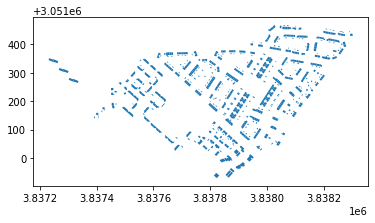

In [192]:
gdf_BC.loc[gdf_BC['batiment_groupe_id']=='uf594560419272_54cd85991256774',].plot()

In [186]:
# all of these building constructions are coded as having the same dpe, because there is only a match between building group and dpe in the relation file, even though the dpe refers probably to a single building or building construction
check2=pd.DataFrame(dpe_bc.loc[dpe_bc['batiment_groupe_id']=='uf594560419272_54cd85991256774',].drop(columns='geometry'))
check2

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,...,conso_5_usages_ef_m2,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale,batiment_construction_id,s_geom_cstr,hauteur,Area_footprint,area_ratio,living_area
2054,2159E0026306B,uf594560419272_54cd85991256774,59456_0139_00058,58 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,NaN,1.0,NaN,...,126.644316,27.459042,NaN,NaN,BATIMENT0000000291225724-1,43.0,5.3,43.271828,0.993718,NaN
2055,2159E0026306B,uf594560419272_54cd85991256774,59456_0139_00058,58 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,NaN,1.0,NaN,...,126.644316,27.459042,NaN,NaN,BATIMENT0000000291226040-1,7.0,9.0,6.577052,1.064307,NaN
2056,2159E0026306B,uf594560419272_54cd85991256774,59456_0139_00058,58 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,NaN,1.0,NaN,...,126.644316,27.459042,NaN,NaN,BATIMENT0000000291226041-1,7.0,9.0,6.731630,1.039867,NaN
2057,2159E0026306B,uf594560419272_54cd85991256774,59456_0139_00058,58 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,NaN,1.0,NaN,...,126.644316,27.459042,NaN,NaN,BATIMENT0000000291226155-1,9.0,9.0,9.334522,0.964163,NaN
2058,2159E0026306B,uf594560419272_54cd85991256774,59456_0139_00058,58 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,NaN,1.0,NaN,...,126.644316,27.459042,NaN,NaN,BATIMENT0000000291226332-1,7.0,9.0,6.731614,1.039869,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82679,2259E1895556I,uf594560419272_54cd85991256774,59456_0222_00026,26 Rue Lucien Bourdon 59146 Pecquencourt,1,maison,avant 1948,1930.0,2.0,NaN,...,72.062337,15.400000,48.6,55.185,BATIMENT0000002207369235-1,150.0,6.3,149.553067,1.002988,78.0
82680,2259E1895556I,uf594560419272_54cd85991256774,59456_0222_00026,26 Rue Lucien Bourdon 59146 Pecquencourt,1,maison,avant 1948,1930.0,2.0,NaN,...,72.062337,15.400000,48.6,55.185,BATIMENT0000002207369244-1,114.0,7.9,113.745325,1.002239,78.0
82681,2259E1895556I,uf594560419272_54cd85991256774,59456_0222_00026,26 Rue Lucien Bourdon 59146 Pecquencourt,1,maison,avant 1948,1930.0,2.0,NaN,...,72.062337,15.400000,48.6,55.185,BATIMENT0000002207369246-1,293.0,8.0,292.493741,1.001731,78.0
82682,2259E1895556I,uf594560419272_54cd85991256774,59456_0222_00026,26 Rue Lucien Bourdon 59146 Pecquencourt,1,maison,avant 1948,1930.0,2.0,NaN,...,72.062337,15.400000,48.6,55.185,BATIMENT0000002207369250-1,358.0,9.0,356.624393,1.003857,78.0


In [187]:
# within this one building group, there are 100 addresses
check2['adresse_geocodee'].drop_duplicates()

2054          58 Avenue Emile Zola 59146 Pecquencourt
2787          31 Rue Hans Andersen 59146 Pecquencourt
3520        11 Rue Jules Mousseron 59146 Pecquencourt
4253             35 Avenue Barrois 59146 Pecquencourt
4986       7 Rue Guy De Maupassant 59146 Pecquencourt
                             ...                     
78286            13 Rue De Mazamet 59146 Pecquencourt
79019    28 Rue Simone De Beauvoir 59146 Pecquencourt
79752            69 Avenue Barrois 59146 Pecquencourt
80485            15 Rue De Carmaux 59146 Pecquencourt
81951        26 Rue Lucien Bourdon 59146 Pecquencourt
Name: adresse_geocodee, Length: 100, dtype: object

In [188]:
# within this one building group, there are 733 building constructions
check2['batiment_construction_id'].drop_duplicates()

2054    BATIMENT0000000291225724-1
2055    BATIMENT0000000291226040-1
2056    BATIMENT0000000291226041-1
2057    BATIMENT0000000291226155-1
2058    BATIMENT0000000291226332-1
                   ...            
2782    BATIMENT0000002207369235-1
2783    BATIMENT0000002207369244-1
2784    BATIMENT0000002207369246-1
2785    BATIMENT0000002207369250-1
2786    BATIMENT0000002207369263-2
Name: batiment_construction_id, Length: 733, dtype: object

In [189]:
# within this one building group, there are 110 DPEs
check2['identifiant_dpe'].drop_duplicates()

2054     2159E0026306B
2787     2159E0026318N
3520     2159E0026325U
4253     2159E0081057W
4986     2159E0081618L
             ...      
79019    2259E1391285H
79752    2259E1489525T
80485    2259E1662360G
81218    2259E1668194Q
81951    2259E1895556I
Name: identifiant_dpe, Length: 110, dtype: object

In [155]:
all(dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0331027C','conso_5_usages_ef_m2'].values==dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0860396L','conso_5_usages_ef_m2'].values)

False

In [156]:
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0331027C','conso_5_usages_ef_m2']

10117    100.0
10118    100.0
10119    100.0
10120    100.0
10121    100.0
         ...  
10845    100.0
10846    100.0
10847    100.0
10848    100.0
10849    100.0
Name: conso_5_usages_ef_m2, Length: 733, dtype: float64

In [157]:
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0860396L','conso_5_usages_ef_m2']

26243    102.0
26244    102.0
26245    102.0
26246    102.0
26247    102.0
         ...  
26971    102.0
26972    102.0
26973    102.0
26974    102.0
26975    102.0
Name: conso_5_usages_ef_m2, Length: 733, dtype: float64

In [163]:
# these three dpes are all assigned to the same building group, but have different addresses and obviously correspond to different individual buildings. however, when combining
dpe.loc[dpe['identifiant_dpe'].isin(['2159E0331027C','2159E0860396L','2259E0934376W'])]

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,surface_habitable_immeuble,surface_habitable_logement,conso_5_usages_ep_m2,conso_5_usages_ef_m2,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale
5684,2159E0331027C,uf594560419272_54cd85991256774,59456_0139_00022,22 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,NaN,79.0,108.000000,100.000000,21.00,NaN,NaN
14738,2159E0860396L,uf594560419272_54cd85991256774,59456_0149_00005,5 Rue Des Freres Grimm 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,NaN,52.0,113.000000,102.000000,22.00,NaN,NaN
36489,2259E0934376W,uf594560419272_54cd85991256774,59456_0040_00039,39 Avenue Barrois 59146 Pecquencourt,1,maison,avant 1948,1930.0,1.0,NaN,NaN,50.0,99.011877,88.432947,18.76,49.998,49.998


In [168]:
# these three dpes are all assigned to the same building group, but have different addresses and obviously correspond to different individual buildings. however, when combining
dpe_bc.loc[dpe_bc['identifiant_dpe'].isin(['2159E0331027C','2159E0860396L','2259E0934376W']),'batiment_construction_id'].drop_duplicates()

10117    BATIMENT0000000291225724-1
10118    BATIMENT0000000291226040-1
10119    BATIMENT0000000291226041-1
10120    BATIMENT0000000291226155-1
10121    BATIMENT0000000291226332-1
                    ...            
10845    BATIMENT0000002207369235-1
10846    BATIMENT0000002207369244-1
10847    BATIMENT0000002207369246-1
10848    BATIMENT0000002207369250-1
10849    BATIMENT0000002207369263-2
Name: batiment_construction_id, Length: 733, dtype: object

In [134]:
# we can see from the batiment construction file that there are indeed 733 BCs that correspond to this batiment groups.
# a problem is that the relation file 'rel_bldgroup_dpe_log' contains building group ids but not building construction ids
# for this group of ~110 DPEs which correspond to 773 BCs, we would want 
gdf_BC.loc[gdf_BC['batiment_groupe_id']=='uf594560419272_54cd85991256774',]

,WKT,batiment_construction_id,batiment_groupe_id,code_departement_insee,code_iris,code_commune_insee,s_geom_cstr,hauteur,altitude_sol,fictive_geom_cstr,geometry,Area_footprint,area_ratio
890579,"MULTIPOLYGON (((714262.8 7030575.7,714262.5 70...",BATIMENT0000000291225724-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,43.0,5.3,23.1,0,"MULTIPOLYGON (((3838028.930 3051388.713, 38380...",43.271828,0.993718
891128,"MULTIPOLYGON (((714159.8 7030482.2,714159.6 70...",BATIMENT0000000291226040-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,7.0,9.0,23.0,0,"MULTIPOLYGON (((3837917.792 3051305.495, 38379...",6.577052,1.064307
891322,"MULTIPOLYGON (((714057.8 7030480.4,714058.3 70...",BATIMENT0000000291226041-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,7.0,9.0,23.1,0,"MULTIPOLYGON (((3837816.283 3051313.402, 38378...",6.731630,1.039867
891445,"MULTIPOLYGON (((714340.9 7030502.2,714344.0 70...",BATIMENT0000000291226155-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,9.0,9.0,22.0,0,"MULTIPOLYGON (((3838099.602 3051308.172, 38381...",9.334522,0.964163
891543,"MULTIPOLYGON (((714184.1 7030589.4,714181.4 70...",BATIMENT0000000291226332-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,7.0,9.0,22.1,0,"MULTIPOLYGON (((3837952.030 3051409.823, 38379...",6.731614,1.039869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
979618,"MULTIPOLYGON (((714136.3 7030108.2,714148.8 70...",BATIMENT0000002207369235-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,150.0,6.3,24.2,0,"MULTIPOLYGON (((3837859.222 3050935.685, 38378...",149.553067,1.002988
979627,"MULTIPOLYGON (((714176.4 7030193.3,714170.9 70...",BATIMENT0000002207369244-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,114.0,7.9,23.1,0,"MULTIPOLYGON (((3837907.077 3051016.527, 38379...",113.745325,1.002239
979628,"MULTIPOLYGON (((714224.3 7030183.3,714211 7030...",BATIMENT0000002207369246-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,293.0,8.0,23.3,0,"MULTIPOLYGON (((3837953.725 3051002.025, 38379...",292.493741,1.001731
979630,"MULTIPOLYGON (((714195.8 7030152.9,714192.4 70...",BATIMENT0000002207369250-1,uf594560419272_54cd85991256774,59,594560101.0,59456.0,358.0,9.0,22.7,0,"MULTIPOLYGON (((3837922.547 3050974.494, 38379...",356.624393,1.003857


In [153]:
dpe.loc[dpe['batiment_groupe_id']=='uf594560419272_54cd85991256774']

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,surface_habitable_immeuble,surface_habitable_logement,conso_5_usages_ep_m2,conso_5_usages_ef_m2,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale
338,2159E0026306B,uf594560419272_54cd85991256774,59456_0139_00058,58 Avenue Emile Zola 59146 Pecquencourt,1,maison,avant 1948,NaN,1.0,NaN,NaN,NaN,137.001544,126.644316,27.459042,NaN,NaN
339,2159E0026318N,uf594560419272_54cd85991256774,59456_0178_00031,31 Rue Hans Andersen 59146 Pecquencourt,1,maison,avant 1948,NaN,1.0,NaN,NaN,NaN,146.749570,136.240213,29.618275,NaN,NaN
340,2159E0026325U,uf594560419272_54cd85991256774,59456_0202_00011,11 Rue Jules Mousseron 59146 Pecquencourt,1,maison,avant 1948,NaN,1.0,NaN,NaN,NaN,144.631452,134.112197,29.133992,NaN,NaN
1193,2159E0081057W,uf594560419272_54cd85991256774,59456_0040_00035,35 Avenue Barrois 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,NaN,54.0,140.000000,130.000000,28.000000,NaN,NaN
1205,2159E0081618L,uf594560419272_54cd85991256774,59456_0177_00007,7 Rue Guy De Maupassant 59146 Pecquencourt,1,maison,avant 1948,1947.0,1.0,NaN,NaN,81.0,97.000000,90.000000,19.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46043,2259E1391285H,uf594560419272_54cd85991256774,59456_0296_00028,28 Rue Simone De Beauvoir 59146 Pecquencourt,1,maison,avant 1948,1930.0,2.0,NaN,NaN,50.0,93.931712,83.351923,17.600000,32.33,38.700
47728,2259E1489525T,uf594560419272_54cd85991256774,59456_0040_00069,69 Avenue Barrois 59146 Pecquencourt,1,maison,avant 1948,NaN,2.0,NaN,NaN,71.0,123.000000,114.000000,25.000000,41.00,53.100
51040,2259E1662360G,uf594560419272_54cd85991256774,59456_0090_00015,15 Rue De Carmaux 59146 Pecquencourt,1,maison,1948-1974,NaN,1.0,NaN,NaN,67.0,325.000000,313.000000,69.000000,67.00,67.000
51170,2259E1668194Q,uf594560419272_54cd85991256774,59456_0090_00015,15 Rue De Carmaux 59146 Pecquencourt,1,maison,1948-1974,NaN,1.0,NaN,NaN,67.0,309.000000,296.000000,65.000000,67.00,67.000


In [124]:
dpe_bc.loc[dpe_bc['identifiant_dpe']=='2159E0860396L','batiment_construction_id']

26243    BATIMENT0000000291225724-1
26244    BATIMENT0000000291226040-1
26245    BATIMENT0000000291226041-1
26246    BATIMENT0000000291226155-1
26247    BATIMENT0000000291226332-1
                    ...            
26971    BATIMENT0000002207369235-1
26972    BATIMENT0000002207369244-1
26973    BATIMENT0000002207369246-1
26974    BATIMENT0000002207369250-1
26975    BATIMENT0000002207369263-2
Name: batiment_construction_id, Length: 733, dtype: object

<AxesSubplot:>

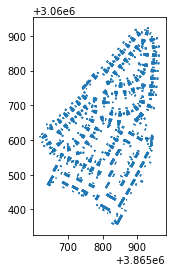

In [87]:
dpe_bc.loc[dpe_bc['cle_interop_adr']=='59616_0087_01463',:].plot()

In [88]:
dpe_bc.loc[dpe_bc['cle_interop_adr']=='59616_0087_01463',:]


,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,...,emission_ges_5_usages_m2,surface_plancher_bas_totale,surface_plancher_haut_totale,batiment_construction_id,s_geom_cstr,hauteur,geometry,Area_footprint,area_ratio,living_area
224715,2259E1077486C,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,74.0,47.25,47.55,BATIMENT0000000056818418-1,45.0,1.8,"MULTIPOLYGON (((3865916.426 3060872.901, 38659...",44.391955,1.013697,76.0
224716,2259E1077486C,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,74.0,47.25,47.55,BATIMENT0000000056820431-1,61.0,2.6,"MULTIPOLYGON (((3865815.644 3060645.371, 38658...",60.753242,1.004062,76.0
224717,2259E1077486C,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,74.0,47.25,47.55,BATIMENT0000000056820480-1,28.0,2.9,"MULTIPOLYGON (((3865752.155 3060680.025, 38657...",27.447865,1.020116,76.0
224718,2259E1077486C,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,74.0,47.25,47.55,BATIMENT0000000056820526-1,49.0,2.6,"MULTIPOLYGON (((3865730.973 3060726.402, 38657...",48.973404,1.000543,76.0
224719,2259E1077486C,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,74.0,47.25,47.55,BATIMENT0000000056820529-1,35.0,3.8,"MULTIPOLYGON (((3865931.262 3060607.553, 38659...",35.254548,0.992780,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228142,2259E1091814E,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,77.0,47.25,47.55,BATIMENT0000000289975870-1,9.0,6.0,"MULTIPOLYGON (((3865747.002 3060563.903, 38657...",9.262307,0.971680,76.0
228143,2259E1091814E,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,77.0,47.25,47.55,BATIMENT0000000289975871-1,10.0,6.0,"MULTIPOLYGON (((3865742.916 3060563.089, 38657...",10.234400,0.977097,76.0
228144,2259E1091814E,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,77.0,47.25,47.55,BATIMENT0000000289975873-1,18.0,6.0,"MULTIPOLYGON (((3865756.123 3060515.064, 38657...",17.816748,1.010285,76.0
228145,2259E1091814E,uf596160250976_a2abb4d165b1810,59616_0087_01463,1463 Rue Antoine Lefevre 59690 Vieux-Condé,1,maison,1948-1974,NaN,2.0,NaN,...,77.0,47.25,47.55,BATIMENT0000000300638070-1,49.0,4.1,"MULTIPOLYGON (((3865747.063 3060447.786, 38657...",48.739407,1.005347,76.0


In [201]:
# rel_batiment_groupe_adresse
# unfortunately the weighting factors described here https://www.bdnb.eu/schema/latest/tables/rel_batiment_groupe_adresse.html are not available in this version
rel_bldgroup_add=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/rel_batiment_groupe_adresse.csv')
rel_bldgroup_add.head()

,WKT,batiment_groupe_id,cle_interop_adr,code_departement_insee,classe,lien_valide
0,"LINESTRING (761233.115215903 6993777.31949394,...",uf592410093053_a1d415976f34e63,02-AISN-276828,59,9.2,0
1,"LINESTRING (737018.212555905 7029276.40487731,...",uf596060246176_2ab4009dc06306d,215015521385539,59,9.2,0
2,"LINESTRING (736937.548040943 7029275.22391438,...",uf596060246517_05b494187023bd3,215015531385538,59,9.2,0
3,"LINESTRING (737208.68570581 7029463.77953027,7...",59606000AR0073_9e3070c26f09079,217041151379714,59,9.2,0
4,"LINESTRING (737414.741112976 7028583.52609755,...",59606000AS0687_a420d270a215d23,219426091385581,59,9.2,0


In [196]:
# there is a many-to-many mapping between addresses and building groups, as shown in the next few cells.
print('N bldg groups',len(rel_bldgroup_add['batiment_groupe_id'].drop_duplicates()))
print('N addresses',len(rel_bldgroup_add['cle_interop_adr'].drop_duplicates()))
print('Total unique records',len(rel_bldgroup_add))

N bldg groups 833538
N addresses 1809692
Total unique records 2337016


In [197]:
rel_bldgroup_add['cle_interop_adr'].value_counts()

59183_3008_00011    104
IMB/59599/S/0K6Z     97
IMB/59599/S/0PZU     97
IMB/59599/S/0Q01     97
IMB/59599/S/0NTS     97
                   ... 
59393_0260_00514      1
59393_0060_00079      1
59393_0060_00078      1
59393_0280_00579      1
SI-A-ST-SPSM5701      1
Name: cle_interop_adr, Length: 1809692, dtype: int64

In [199]:
# some addresses have multiple building grouds
rel_bldgroup_add.loc[rel_bldgroup_add['cle_interop_adr']=='59183_3008_00011',:]

,WKT,batiment_groupe_id,cle_interop_adr,code_departement_insee,classe,lien_valide
289062,"LINESTRING (654194.778393992 7102755.1988446,6...",59183460AM0019_6b0b2b80dcf850b,59183_3008_00011,59,1.1,1
289063,"LINESTRING (654191.849953909 7102755.04165745,...",59183460AM0020_82e79345f9ce6bb,59183_3008_00011,59,1.1,1
289065,"LINESTRING (654166.95 7102766.95,654130.612741...",uf591830071332_182cd4dc42ff42a,59183_3008_00011,59,1.1,1
289066,"LINESTRING (654170.000362506 7102767.10471258,...",uf591830071332_e66b80acdaa5ee0,59183_3008_00011,59,1.1,1
289082,"LINESTRING (654188.745844045 7102754.93105398,...",59183460AM0021_c401891ee66e4af,59183_3008_00011,59,1.1,1
...,...,...,...,...,...,...
289422,"LINESTRING (654161.620037348 7102753.64709617,...",uf591830071016_049aa94859be819,59183_3008_00011,59,1.1,1
289423,"LINESTRING (654167.720063368 7102753.94113317,...",uf591830071016_9155f800be312d3,59183_3008_00011,59,1.1,1
289435,"LINESTRING (654164.676612903 7102753.77967395,...",uf591830071016_e443ecdd4ed2ef3,59183_3008_00011,59,1.1,1
289442,"LINESTRING (654134.574181428 7102752.41663983,...",uf591830071134_b6f46596fa4cab0,59183_3008_00011,59,1.1,1


In [198]:
rel_bldgroup_add['batiment_groupe_id'].value_counts()

uf594560419272_54cd85991256774    872
uf594560365876_d862003c11f123d    719
uf591700063215_1f9d20efff1e048    664
uf592760381753_19d72ff79c66604    576
uf594910325059_84f9639479cbabe    537
                                 ... 
59512000DY0132_03bafd2be9c9cee      1
uf595130286294_80453ffb5aaaa49      1
59514000AB0050_cdbc01c784e5933      1
59514000AB0283_dd800e6ff2f93f8      1
59183540AC0339_8f2d3674240086d      1
Name: batiment_groupe_id, Length: 833538, dtype: int64

In [211]:
# some building groups are split over many addresses
rel_bg_adr_gdf = import_csv_w_wkt_to_gdf('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/rel_batiment_groupe_adresse.csv',crs=2154,geometry_col='WKT')
rel_bg_adr_gdf

,WKT,batiment_groupe_id,cle_interop_adr,code_departement_insee,classe,lien_valide,geometry
0,"LINESTRING (761233.115215903 6993777.31949394,...",uf592410093053_a1d415976f34e63,02-AISN-276828,59,9.2,0,"LINESTRING (761233.115 6993777.319, 761237.127..."
1,"LINESTRING (737018.212555905 7029276.40487731,...",uf596060246176_2ab4009dc06306d,215015521385539,59,9.2,0,"LINESTRING (737018.213 7029276.405, 736948.476..."
2,"LINESTRING (736937.548040943 7029275.22391438,...",uf596060246517_05b494187023bd3,215015531385538,59,9.2,0,"LINESTRING (736937.548 7029275.224, 736939.043..."
3,"LINESTRING (737208.68570581 7029463.77953027,7...",59606000AR0073_9e3070c26f09079,217041151379714,59,9.2,0,"LINESTRING (737208.686 7029463.780, 737207.317..."
4,"LINESTRING (737414.741112976 7028583.52609755,...",59606000AS0687_a420d270a215d23,219426091385581,59,9.2,0,"LINESTRING (737414.741 7028583.526, 737412.058..."
...,...,...,...,...,...,...,...
2337011,"LINESTRING (654327.885356547 7103660.76091104,...",59183540AO0050_a1b63222575bcad,SI-A-ST-SPSM5696,59,9.2,0,"LINESTRING (654327.885 7103660.761, 654323.846..."
2337012,"LINESTRING (654385.364026168 7103642.35043743,...",59183540AN0045_c50f387dcbcf6f4,SI-A-ST-SPSM5697,59,9.2,0,"LINESTRING (654385.364 7103642.350, 654368.177..."
2337013,"LINESTRING (654360.100110322 7103629.28792649,...",59183540AN0044_0a0f649eb28dc9b,SI-A-ST-SPSM5698,59,9.2,0,"LINESTRING (654360.100 7103629.288, 654368.552..."
2337014,"LINESTRING (654330.246736249 7103644.6207643,6...",59183540AO0054_c1a92c3169b54c6,SI-A-ST-SPSM5699,59,9.2,0,"LINESTRING (654330.247 7103644.621, 654328.497..."


<AxesSubplot:>

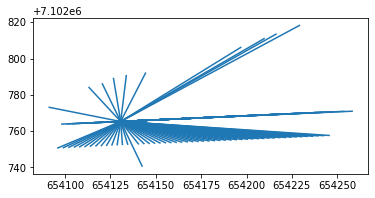

In [213]:
# not sure what the geometries refer to? they are maybe the centre of a building plus the centre of an address?
rel_bg_adr_gdf.loc[rel_bg_adr_gdf['cle_interop_adr']=='59183_3008_00011'].plot()

In [225]:
rel_bg_adr_gdf.loc[rel_bg_adr_gdf['cle_interop_adr']=='59183_3008_00011',:]

,WKT,batiment_groupe_id,cle_interop_adr,code_departement_insee,classe,lien_valide,geometry
289062,"LINESTRING (654194.778393992 7102755.1988446,6...",59183460AM0019_6b0b2b80dcf850b,59183_3008_00011,59,1.1,1,"LINESTRING (654194.778 7102755.199, 654130.613..."
289063,"LINESTRING (654191.849953909 7102755.04165745,...",59183460AM0020_82e79345f9ce6bb,59183_3008_00011,59,1.1,1,"LINESTRING (654191.850 7102755.042, 654130.613..."
289065,"LINESTRING (654166.95 7102766.95,654130.612741...",uf591830071332_182cd4dc42ff42a,59183_3008_00011,59,1.1,1,"LINESTRING (654166.950 7102766.950, 654130.613..."
289066,"LINESTRING (654170.000362506 7102767.10471258,...",uf591830071332_e66b80acdaa5ee0,59183_3008_00011,59,1.1,1,"LINESTRING (654170.000 7102767.105, 654130.613..."
289082,"LINESTRING (654188.745844045 7102754.93105398,...",59183460AM0021_c401891ee66e4af,59183_3008_00011,59,1.1,1,"LINESTRING (654188.746 7102754.931, 654130.613..."
...,...,...,...,...,...,...,...
289422,"LINESTRING (654161.620037348 7102753.64709617,...",uf591830071016_049aa94859be819,59183_3008_00011,59,1.1,1,"LINESTRING (654161.620 7102753.647, 654130.613..."
289423,"LINESTRING (654167.720063368 7102753.94113317,...",uf591830071016_9155f800be312d3,59183_3008_00011,59,1.1,1,"LINESTRING (654167.720 7102753.941, 654130.613..."
289435,"LINESTRING (654164.676612903 7102753.77967395,...",uf591830071016_e443ecdd4ed2ef3,59183_3008_00011,59,1.1,1,"LINESTRING (654164.677 7102753.780, 654130.613..."
289442,"LINESTRING (654134.574181428 7102752.41663983,...",uf591830071134_b6f46596fa4cab0,59183_3008_00011,59,1.1,1,"LINESTRING (654134.574 7102752.417, 654130.613..."


<AxesSubplot:>

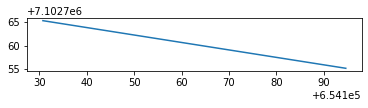

In [227]:
rel_bg_adr_gdf.loc[rel_bg_adr_gdf['batiment_groupe_id']=='59183460AM0019_6b0b2b80dcf850b',:].plot()

<AxesSubplot:>

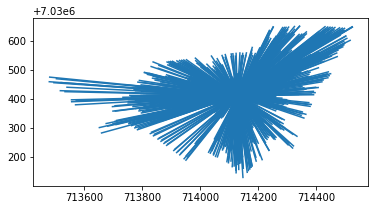

In [230]:
rel_bg_adr_gdf.loc[rel_bg_adr_gdf['batiment_groupe_id']=='uf594560419272_54cd85991256774'].plot()

In [231]:
dpe_bc['BG_adr']=dpe_bc['batiment_groupe_id']+'-'+dpe_bc['cle_interop_adr']
dpe_bc.head()

,identifiant_dpe,batiment_groupe_id,cle_interop_adr,adresse_geocodee,arrete_2021,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,nombre_niveau_logement,nombre_niveau_immeuble,...,surface_plancher_bas_totale,surface_plancher_haut_totale,batiment_construction_id,s_geom_cstr,hauteur,geometry,Area_footprint,area_ratio,living_area,BG_adr
0,2100E0078172Q,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,...,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356,61.00,595070000A5692_88fd84fef2f8a99-59507_0890_00200
1,2159E0078306B,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,2006-2012,2006.0,1.0,NaN,...,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356,60.66,595070000A5692_88fd84fef2f8a99-59507_0890_00200
2,2159E0093983A,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,2006-2012,2006.0,1.0,NaN,...,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356,43.20,595070000A5692_88fd84fef2f8a99-59507_0890_00200
3,2159E0196882R,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,2006-2012,2006.0,1.0,NaN,...,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356,39.78,595070000A5692_88fd84fef2f8a99-59507_0890_00200
4,2159E0322387U,595070000A5692_88fd84fef2f8a99,59507_0890_00200,200 Rue Roger Salengro 59790 Ronchin,1,appartement,1989-2000,1989.0,1.0,NaN,...,NaN,NaN,BATIMENT0000000288124473-1,420.0,14.0,"MULTIPOLYGON (((3832855.267 3078032.630, 38328...",418.59511,1.003356,42.00,595070000A5692_88fd84fef2f8a99-59507_0890_00200


In [232]:
len(dpe_bc['BG_adr'].drop_duplicates())

42434

In [234]:
dpe_bc['BG_adr'].value_counts()

uf596160250976_a2abb4d165b1810-59616_0087_01463      2288
uf596160250976_a2abb4d165b1810-59616_0590_00986      2288
uf594560419272_54cd85991256774-59456_0139_00004      2199
uf596160250976_a2abb4d165b1810-59616_g7sk71_01008    1716
uf596160250976_a2abb4d165b1810-59616_g7sk71_00990    1716
                                                     ... 
59117000AE0024_7c6c898d5cdef86-59117_0200_00020         1
59343000AB0082_a8bf06eb37ce83d-59343_0382_00010         1
595570000U2319_ba949caafe4e35c-59557_0089_00015         1
uf593680151497_1e473cfc28743b1-59368_0260_00023         1
uf591050400868_6dfa587115fb757-59105_0080_00141         1
Name: BG_adr, Length: 42434, dtype: int64

In [235]:
dpe['BG_adr'].value_counts()

59011000AH0349_edfa81f5f59fb1f-59011_0040_00001    197
59360000AO0303_95a684b90fc52ca-59360_0035_00016    133
uf590090003790_022d159ffff0ebf-59009_0321_00008     96
59017000AP0113_fc21301abe5158c-59017_1290_00280     68
59328000AS0847_58cdef49f15afd3-59328_0060_00100     61
                                                  ... 
59599000EP0286_429495750d842f6-59599_3870_00034      1
59183000BD0140_2016e488f175d67-59183_2990_00048      1
uf590140396992_d3d3faec577cb48-59014_0880_00002      1
59332000AB0396_3ff7d6a489b106f-59332_0280_00013      1
uf591050400868_6dfa587115fb757-59105_0080_00141      1
Name: BG_adr, Length: 42434, dtype: int64

In [238]:
dpe.loc[dpe['BG_adr']=='59011000AH0349_edfa81f5f59fb1f-59011_0040_00001','identifiant_dpe'].drop_duplicates()

49593    2259E1590981X
49594    2259E1591018I
49596    2259E1591047L
49621    2259E1593027P
49622    2259E1593134S
             ...      
52116    2259E1718671B
52117    2259E1718676G
52119    2259E1718683N
52120    2259E1718685P
52121    2259E1718696A
Name: identifiant_dpe, Length: 197, dtype: object

So let's see what the dpe file itself looks like, in terms of relating building characteristics to energy and emission intensities

In [242]:
# that is what we would expect
dpe_log.groupby('periode_construction_dpe')['conso_5_usages_ef_m2'].mean()

periode_construction_dpe
1948-1974     224.655746
1975-1977     209.525209
1978-1982     171.222287
1983-1988     152.994479
1989-2000     130.205174
2001-2005     119.930429
2006-2012     108.968605
2013-2021      77.655256
après 2021     68.172130
avant 1948    196.454559
Name: conso_5_usages_ef_m2, dtype: float64

In [243]:
# houses are most inefficient, but not a big diff
dpe_log.groupby('type_batiment_dpe')['conso_5_usages_ef_m2'].mean()

type_batiment_dpe
appartement    166.961430
immeuble       183.278464
maison         197.501792
Name: conso_5_usages_ef_m2, dtype: float64

In [247]:
# group by age and type
dpe_log.groupby(['type_batiment_dpe','periode_construction_dpe'])['conso_5_usages_ef_m2'].mean()

type_batiment_dpe  periode_construction_dpe
appartement        1948-1974                   212.828743
                   1975-1977                   225.068510
                   1978-1982                   152.370562
                   1983-1988                   141.288852
                   1989-2000                   115.112095
                   2001-2005                   100.778063
                   2006-2012                   100.874588
                   2013-2021                    84.114231
                   après 2021                   79.718775
                   avant 1948                  174.657127
immeuble           1948-1974                   248.180998
                   1975-1977                   228.067279
                   1978-1982                   147.293533
                   1983-1988                    76.353419
                   1989-2000                   104.638297
                   2001-2005                    68.176627
                   2006-2012

In [248]:
dpe_log.groupby(['type_batiment_dpe','periode_construction_dpe'])['emission_ges_5_usages_m2'].mean()

type_batiment_dpe  periode_construction_dpe
appartement        1948-1974                   39.976852
                   1975-1977                   45.109548
                   1978-1982                   28.613606
                   1983-1988                   23.030363
                   1989-2000                   14.378495
                   2001-2005                   12.537631
                   2006-2012                   12.734546
                   2013-2021                   14.363900
                   après 2021                  17.595911
                   avant 1948                  23.567659
immeuble           1948-1974                   49.809970
                   1975-1977                   41.350000
                   1978-1982                   30.650000
                   1983-1988                    5.600000
                   1989-2000                   13.711538
                   2001-2005                    4.990000
                   2006-2012                